# Classification of anomalous timeseries

In Stackstate we are challenged with a number of problems from IT operations area that we are solving using Machine Learning techniques.

One of the problems that is very important is classification of timeseries for further automatic problem detection and root cause analysis at scale.
Usually the metrics are coming from different sources and monitoring tools. The metrics typically are ["Golden signals"](https://landing.google.com/sre/sre-book/chapters/monitoring-distributed-systems/#xref_monitoring_golden-signals), resource utilization (CPU/RAM/Disk), business KPIs (Sales, Latency).

In this notebook I'd like to give an introduction of how classification of time series can be performed. In order to do that I formulate the following questions.

## Research Questions

1. What is timeseries anomaly, what are the characteristics of anomaly? 
2. Can timeseries anomaly be detected using a classifier?
3. How to solve class disbalances?
4. How many samples is required to reliably detect anomaly?


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Including parent path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import os
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta as td

from sklearn.model_selection import train_test_split

import unittest
import numpy as np
import pandas as pd

from preprocessing.test_common import make_labels, make_series
from preprocessing.helper import TimeseriesHelper
from preprocessing.preprocessing import TimeSeriesPreprocessor
from preprocessing.feature_engineering import TimeSeriesFeatureEngineering
from models.xgboost import XGBoostModel
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1. Loading the data

I have chosen the NAB dataset for anomaly research because it is publicly available dataset that contains a representative set of timeseries with labeled anomalies.

It is very important that the anomalies are labeled by the experts as they provide necessary context and establish necessary casual relationship between change in metric and corresponding issue. 

If the time series is not labled then it is difficult to conclude if the change in the signal that reached a threshold or a frequency change indicating typical changepoint or actual problem.

In [4]:
helper = TimeseriesHelper()

metric_map = helper.load_multiple_series(
    ["realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv", 
     "realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv",
     "realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv",
     "realAWSCloudwatch/grok_asg_anomaly.csv",
     "realTweets/Twitter_volume_AMZN.csv",
     "realTweets/Twitter_volume_UPS.csv",
     "realTraffic/TravelTime_387.csv",
     "realKnownCause/ec2_request_latency_system_failure.csv",
     "realKnownCause/machine_temperature_system_failure.csv",
     "realKnownCause/ambient_temperature_system_failure.csv"])

## 2. How does anomaly look like and how often it occurs?

Let's now examine the number of NAB metrics we preselected, plot them with corresponding labels and give the definition of anomaly according to what the experts thought the anomaly was.

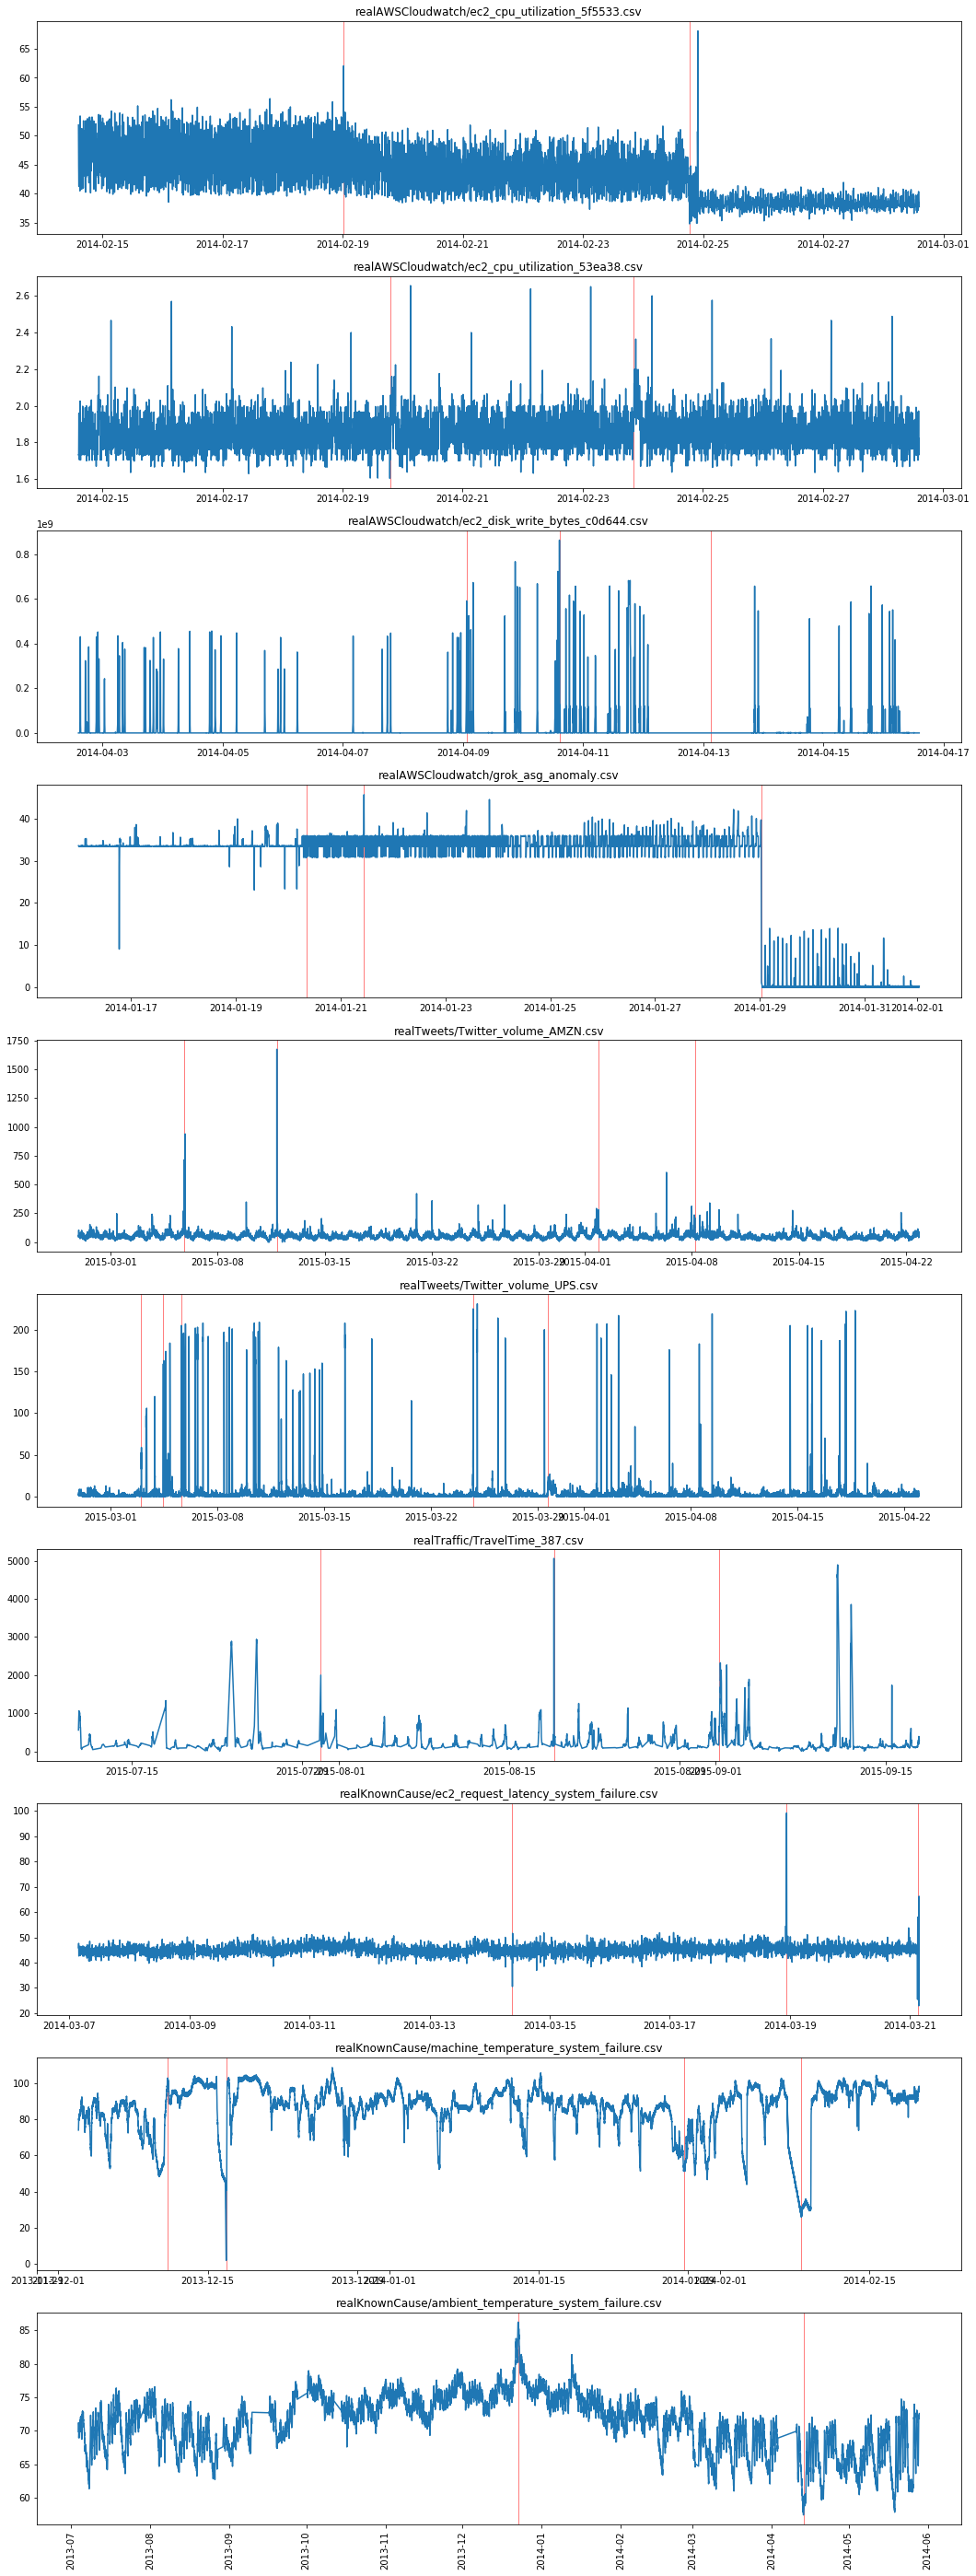

In [5]:
helper.plot_metrics(metric_map, figsize=(18, 50))

## Anomaly Definition

From the charts above it is clear that the anomaly is:
- Sudden metric value spike or collapse
- Sudden change in variance
- Sudden level shift
- Any combination of one of the mentioned above

Anomalies are quite rare. I foresee issues due to class disbalance where it is easier for a model to always say "No Anomaly" and still get 99.99% accuracy.

Note that we are analyzing the anomalies pretty much without the context, observing the metric data itself. 


## 3 Data Preprocessing and Feature Engineering

Before extracting features from time series it is always a good practice to perform data cleaning and preprocessing.

I will execute the following preprocessing steps:
1. Cleaning from missing values
2. Aggregating into 5 minute buckets.
3. If after aggregation there are missing values they are imputed using backfill and forwardfill methods.

The result dataset is ready for feature engineering. 

In [6]:
ec2_request_latency_system_failure_file = "realKnownCause/ec2_request_latency_system_failure.csv"
ec2_cpu_utilization_failure_file = "realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv" 
Twitter_volume_AMZN_file = "realTweets/Twitter_volume_AMZN.csv"
machine_temperature_system_failure_file = "realKnownCause/machine_temperature_system_failure.csv"

raw_datasets = {
   "ec2_request_latency_system_failure" : metric_map[ec2_request_latency_system_failure_file],
   "ec2_cpu_utilization_5f5533" : metric_map[ec2_cpu_utilization_failure_file],
   "Twitter_volume_AMZN": metric_map[Twitter_volume_AMZN_file],
   "machine_temperature_system_failure": metric_map[machine_temperature_system_failure_file]
}

input_variables = ['y']
output_variable = 'label'

In [7]:
dataset_id = "ec2_request_latency_system_failure"
roll_shift = 20
# dataset_id = "ec2_cpu_utilization_5f5533"
# dataset_id = "Twitter_volume_AMZN"
# dataset_id = "machine_temperature_system_failure"


### 3.1 Preprocessing

I will execute the following preprocessing steps:
1. Cleaning from missing values
2. Aggregating into 5 minute buckets.
3. If after aggregation there are missing values they are imputed using backfill and forwardfill methods.

The result dataset is ready for feature engineering. 

In [ ]:

preprocessor = TimeSeriesPreprocessor(
    window_size_seconds = 7200 * 3,
    window_shift = 300,
    horizon_shift_seconds = 3600,
    probe_period_seconds = 300,
    scaler = MinMaxScaler())

series = preprocessor.prepare_series(raw_datasets[dataset_id],
        input_vars = input_variables, output_vars = [output_variable],
        numeric_vars = input_variables, auto_impute = input_variables)


In [ ]:
series.head()

### 3.2 Automatic Feature Engineering

Feature extraction and engineering is laborious process that takes considerable amount of time therefore I'd like to perform it automatically. 

For this purpose I will use [tsfresh](https://tsfresh.readthedocs.io/en/latest/) library that does automatic feature extraction of around [700 features](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) and then execute statistical tests to select only those features that are relevant for classification task. For more details on how it does that I am forwarding the reader to the documentation on [feature extraction](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html) and [feature filtering](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html)

We extract and select the number of features from rolling window of 20 points which corresponds to ~ 100 minutes of time.

In [ ]:
feature_engineering = TimeSeriesFeatureEngineering(
      x_columns = input_variables,
      roll_shift = roll_shift,
      ts_variable = 'timestamp',
      y_column = output_variable)

In [ ]:
dataset = feature_engineering.make_features(series)
dataset.to_csv(f"anomaly/{dataset_id}_{window_size}.csv")

In [ ]:
dataset.head()

Since feature engineering is quite CPU and RAM intensive process I dont want to repeat it often during experimenting therefore for all 4 datasets and different window size I have created a number of feature datasets once and I will reuse them in further experiments.

## 4. Model training

In [ ]:
all_window_sizes = [5, 10, 15, 20, 25, 30, 35]
def load_datasets():
    feature_datasets = {}
    for dataset_id in raw_datasets.keys():
        feature_datasets[dataset_id] = {}
        for window_size in all_window_sizes:
            feature_datasets[dataset_id][window_size] = pd.read_csv(f"anomaly/{dataset_id}_{window_size}.csv")
    return feature_datasets

feature_datasets = load_datasets()

I am splitting the dataset to train/validation/test sets as always in such cases:


In [ ]:
def training_dataset(dataset):
    train_test_split_ratio = 0.2
    train_valid_split_ratio = 0.2
    seed = 42

    input_features = list(dataset.columns)
    input_features.remove(output_variable)

    X_train, X_test, y_train, y_test = train_test_split(dataset[input_features], dataset[output_variable], test_size=train_test_split_ratio, random_state = seed)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = train_valid_split_ratio, random_state = seed)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


### 4.1 Training Gradient Boosting tree model

I am going to train Gradient Boosting Tree as a classifier. This type of model has very good performance although it is also prone to overfitting.

In [ ]:
model = XGBoostModel()

dataset = feature_datasets["ec2_request_latency_system_failure"][20]
X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)

model.fit(X_train.as_matrix(), y_train.as_matrix(), X_valid.as_matrix(), y_valid.as_matrix())

Y_train_pred = model.predict(X_train.as_matrix())
helper.print_results("Training", helper.evaluate(y_train, Y_train_pred))

Y_valid_pred = model.predict(X_valid.as_matrix())
helper.print_results("Validation", helper.evaluate(y_valid, Y_valid_pred))

y_test_pred = model.predict(X_test.as_matrix())
helper.print_results("Test", helper.evaluate(y_test, y_test_pred))


Not bad considering the fact that there is only ~1 % positive samples 

The result overview over all 4 series is given below:

| F1 scores                   | training | validation | test |
|-----------------------------|----------|------------|------|
| request latency failure     | 0.98     | 1.0        | 1.0  |
| cpu utilization failure     | 0.68     | 0.62       | 0.47 |
| twitter volume AMZN         | 0.83     | 0.74       | 0.61 |
| Machine temperature failure | 0.60     | 0.60       | 0.5  |

It seems that in certain cases the classifier a bit overfits the data.
It is also noticible that performance is not great on some datasets and from confusion matrix it looks like classifier tends to infer "not a anomaly" quite often.

### 4.2 Fixing Class Disbalance with Syntetic Minority Oversampling

As it was expected the anomalies are quite rare therefore one of the big challenges in machine learning on anomalous time series is how to train decent classifier with only a couple anomalous samples.

In order to fix the class disblance I am going to artificially increase the number of anomalous samples by using [Synthetic Minority Over-sampling Technique](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html). This will allow to balance the number of positive and negative samples and I avoid cheap wins like always detect "Not anomaly".

The code and results of those experiments are given below:

In [ ]:
dataset = feature_datasets["ec2_request_latency_system_failure"][20]

X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)

print("class distribution in original training data.\n", y_train.groupby(by=lambda v: y_train.loc[v]).count())
X_upsampled, y_upsampled = feature_engineering.class_imbalance_fix(X_train, y_train, ratio=0.05)
elements, counts_elements = np.unique(y_upsampled, return_counts=True)
print("class distribution in upsampled training data.")
print(elements)
print(counts_elements)

model = XGBoostModel()
model.fit(X_upsampled, y_upsampled, X_valid.as_matrix(), y_valid.as_matrix())

Y_train_pred = model.predict(X_train.as_matrix())
helper.print_results("Training", helper.evaluate(y_train, Y_train_pred))

Y_valid_pred = model.predict(X_valid.as_matrix())
helper.print_results("Validation", helper.evaluate(y_valid, Y_valid_pred))

y_test_pred = model.predict(X_test.as_matrix())
helper.print_results("Test", helper.evaluate(y_test, y_test_pred))


It looks like with the increasing of the number of positive samples using SMOTE our model perform slightly better.

| F1 scores                   | training | validation | test |
|-----------------------------|----------|------------|------|
| request latency failure     | 0.98     | 1.0        | 1.0  |
| cpu utilization failure     | 0.94     | 0.66       | 0.8  |
| twitter volume AMZN         | 0.75     | 0.51       | 0.65 |
| Machine temperature failure | 0.58     | 0.51       | 0.44 |


It seems that syntetic samples improve f1 score on around 5-10%. But it also looks like the total number of samples matters therefore I will check how the number of syntetic samples relate impacts the performance


### 4.3 How number of syntetic samples impacts the classifier performance

Let's see what is the best ratio given the number of syntetic samples for the "Machine temperature".

In [ ]:
def calculate_metrics(dataset): 
    X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)
    f1scores = []
    precisions = []
    recalls = []
    ratios = []    
    for i in range(0, 21):
        ratio = float(i) / 20.0
        if i > 0:            
            X_upsampled, y_upsampled = feature_engineering.class_imbalance_fix(X_train, y_train, ratio = ratio)
        else:
            X_upsampled, y_upsampled = X_train.as_matrix(), y_train.as_matrix()

        model = XGBoostModel()
        model.fit(X_upsampled, y_upsampled, X_valid.as_matrix(), y_valid.as_matrix())

        y_test_pred = model.predict(X_test.as_matrix())
        result = helper.evaluate(y_test, y_test_pred)
        f1_score = result["f1_score"]
        precision = result["precision"]
        recall = result["recall"]
        f1scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
        ratios.append(ratio)
    return f1scores, precisions, recalls, ratios

def classifier_performance_vs_syntetic_minority_ratio():
    all_f1scores = {}
    all_precisions = {}
    all_recalls = {}
    ratios = []
    window_size = 20

    for dataset_id in feature_datasets.keys():
        f1scores, precisions, recalls, ratios = calculate_metrics(feature_datasets[dataset_id][window_size])
        all_precisions[dataset_id] = precisions
        all_recalls[dataset_id] = recalls
        all_f1scores[dataset_id] = f1scores
    return all_f1scores, all_precisions, all_recalls, ratios

all_f1scores_ratio, all_precisions_ratio, all_recalls_ratio, ratios = \
    classifier_performance_vs_syntetic_minority_ratio()

In [ ]:
def plot_metrics(name, scores, ratios):
    plt.figure(figsize=(10, 6))
    for dataset_id in scores.keys():
        plt.plot(ratios, scores[dataset_id], label=dataset_id)        
        plt.legend(title=f'{name}:')
        
plot_metrics("f1 score", all_f1scores_ratio, ratios)

From the chart above it seems that it is enough to sample only a tiny fraction of anomalos samples, otherwise the performance of the classifier degrades considerably.

### 4.4 How number of syntetic samples impacts the number false negatives and false positives


In [ ]:
plot_metrics("precision score", all_precisions_ratio, ratios)

In [ ]:
plot_metrics("recall score", all_recalls_ratio, ratios)

### 4.5 How window size impacts the classifier performance

 

In [ ]:
def train_and_test(dataset, ratio): 
    X_train, X_valid, X_test, y_train, y_valid, y_test = training_dataset(dataset)
    
    model = XGBoostModel()
    if ratio > 0.0:
        X_upsampled, y_upsampled = feature_engineering.class_imbalance_fix(X_train, y_train, ratio = ratio)
    else:
        X_upsampled, y_upsampled = X_train.as_matrix(), y_train.as_matrix()        
    model.fit(X_upsampled, y_upsampled, X_valid.as_matrix(), y_valid.as_matrix())

    y_test_pred = model.predict(X_test.as_matrix())
    
    result = helper.evaluate(y_test, y_test_pred)
    
    return result["f1_score"], result["precision"], result["recall"]

def classifier_performance_given_window_size(sm_ratio):
    all_f1scores = {}
    all_precisions = {}
    all_recalls = {}
    
    for dataset_id in feature_datasets.keys():
        all_f1scores[dataset_id] = []
        all_precisions[dataset_id] = []
        all_recalls[dataset_id] = []

        for window_size in all_window_sizes:
            f1score, precision, recall = train_and_test(feature_datasets[dataset_id][window_size], sm_ratio)
            all_f1scores[dataset_id].append(f1score)
            all_precisions[dataset_id].append(precision)
            all_recalls[dataset_id].append(recall)
    return all_f1scores, all_precisions, all_recalls

all_f1scores, all_precisions, all_recalls = classifier_performance_given_window_size(sm_ratio=0.0)
all_f1scores_sm, all_precisions_sm, all_recalls_sm = classifier_performance_given_window_size(sm_ratio=0.05)

In [ ]:
def plot_2_graphs(name1, name2, scores1, scores2, ratios):
    fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(16, 5))
    def subplot(ax, name, scores, x):        
        ax.set_title(name)
        for dataset_id in scores.keys():
            ax.plot(x, scores[dataset_id], label=dataset_id)        
        ax.legend(title=f'{name}:')
    subplot(axes[0][0], name1, scores1, ratios)
    subplot(axes[0][1], name2, scores2, ratios)

plot_2_graphs("f1 score (no smo)", "f1 score (smo)", all_f1scores, all_f1scores_sm, all_window_sizes)

### 4.6 How window size impacts the number of false negatives and false positives

In [ ]:
plot_2_graphs("precision score (no smo)", "precision score (smo)", \
              all_precisions, all_precisions_sm, all_window_sizes)

In [ ]:
plot_2_graphs("recall score (no smo)", "recall score (smo)", \
              all_recalls, all_recalls_sm, all_window_sizes)

## 5. Conclusions

Time series classification is a very important in detecting operational problems and root cause analysis.

Anomalies in general and in time series in particular are relatively infrequent but may cause serious problems. Detecting and classifying anomalies in timeseries is an important task. 

In order to perform anomaly detection the researcher will face the number of issues which he should be prepared for.
Firstly it is required to use effective mechanism to do feature extraction and selection from timeseries. This can be effectively solved using frameworks such as **tsfresh**. 

The other problem is that anomalies are rather infrequent therefore the number of anomalous samples will be very low.